In [21]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import preproccessing as prep
from evaluation import show_scenarios_evaluation
from regime_switching_brownian_motion import RegimeSwitching
from independent_lognormal_model import IndependentLogNormal



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def convert_regime_params(params: pd.Series, k):
    """
    params: scipy stats regime params object
    k: number of regimes

    returns annulised params tumple (mean, sigma, transition matrix)
    """
    mu = np.zeros(k)
    sigmas = np.zeros(k)
    transition_matrix = np.zeros((k,k))
    
    for i in range (k):
        mu[i] = params[f'const[{i}]']
        sigmas[i] = np.sqrt(params[f'sigma2[{i}]'])
        
    for i in range(k):
        for j in range(k-1):
            transition_matrix[i,j] = params[f'p[{i}->{j}]']

    transition_matrix[:,-1] = 1 - transition_matrix.sum(axis=1)

            
    return mu, sigmas, transition_matrix

def params_summary(mus,sigmas,transition_matrix,current_regime):
    print('mus: ')
    print(mus * 12)
    print('sigmas: ')
    print(sigmas * np.sqrt(12))
    print('transition matrix: ')
    print(transition_matrix)
    print('current_regime: ')
    print(current_regime)

def estimate_markov_regime_switching_params(data,period):
    n_regimes = 2
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True
    )

    result = model.fit() 

    mus, sigmas, transition_matrix = convert_regime_params(result.params, n_regimes)

    current_regime = np.argmax([result.smoothed_marginal_probabilities[0].iloc[-1],result.smoothed_marginal_probabilities[1].iloc[-1]])

    #return {'mus':mus, 'sigmas': sigmas, 'transition_matrix': transition_matrix, 'current_regime': current_regime}
    return mus,sigmas,transition_matrix,current_regime

In [23]:
def show_RSLN_scenarios_evaluation(mus, sigmas, transition_matrix, initial_values, current_regime, dt, n_scenarios, n_steps, hist):
    
    model = RegimeSwitching(
    models=[IndependentLogNormal(mu=mus[0],sigma=[sigmas[0]]),
            IndependentLogNormal(mu=mus[1],sigma=[sigmas[1]])],
    probs=transition_matrix
    )

    scenarios = model.scenarios(initial_values,current_regime,dt,n_steps, n_scenarios)
    scenarios = pd.DataFrame(data=scenarios, index=range(n_scenarios), columns=range(n_steps+1))

    show_scenarios_evaluation(scenarios,hist)

In [5]:
#'acwi_25.08.23.csv' - curvo file
acwi = pd.read_csv('acwi_25.08.23.csv',index_col='Date', parse_dates=True)
acwi = acwi.squeeze()
acwi.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 428 entries, 1987-12-01 to 2023-07-01
Series name: MSCI ACWI
Non-Null Count  Dtype  
--------------  -----  
428 non-null    float64
dtypes: float64(1)
memory usage: 6.7 KB


<AxesSubplot:xlabel='Date'>

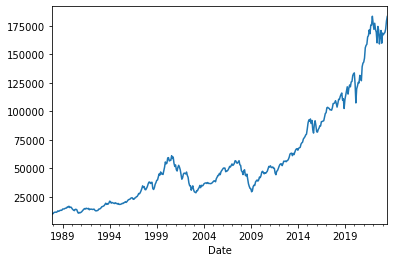

In [6]:
acwi.plot()

<AxesSubplot:xlabel='Date'>

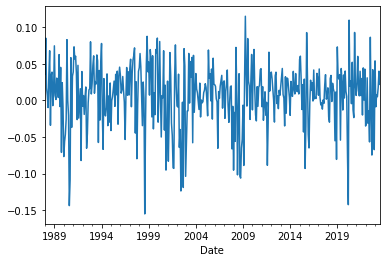

In [7]:

acwi_returns = prep.log_returns(acwi)
display(acwi_returns.plot())


<AxesSubplot:xlabel='MSCI ACWI', ylabel='Count'>

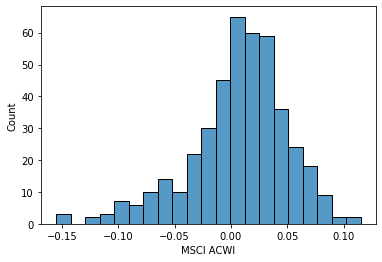

In [8]:
sns.histplot(data=acwi_returns)

In [9]:
periods = [('1988-01-01', '2023-07-01'),
           ('1988-01-01', '2019-12-31'),
           ('1993-01-01', '2023-07-01'),
           ('1994-01-01', '2023-07-01'),
           ('2003-07-01', '2023-07-01'),
           ('1990-01-01', '2019-12-01'),
           ('1990-01-01', '2023-12-01'),
           ('2003-01-01', '2019-12-01'),
           ('2003-01-01', '2014-12-01'),
           ('2003-01-01', '2015-12-31')
           ]

prep.asset_stats(acwi_returns, periods)


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1988-01-01, 2023-07-01)",0.081733,0.149146,-0.752104,1.046907,1.201552,-0.532364
"(1988-01-01, 2019-12-31)",0.080875,0.147638,-0.771985,0.986771,1.193709,-0.532364
"(1993-01-01, 2023-07-01)",0.083378,0.146611,-0.756393,1.111305,1.261200,-0.532364
"(1994-01-01, 2023-07-01)",0.075583,0.146863,-0.744435,1.132014,1.075167,-0.532364
"(2003-07-01, 2023-07-01)",0.086909,0.132992,-0.713923,1.652872,1.482332,-0.481111
"(1990-01-01, 2019-12-01)",0.070984,0.148877,-0.774547,0.948744,0.953616,-0.532364
"(1990-01-01, 2023-12-01)",0.072948,0.150338,-0.752420,1.013315,0.989601,-0.532364
"(2003-01-01, 2019-12-01)",0.085253,0.126505,-0.704987,1.339804,1.513006,-0.481111
"(2003-01-01, 2014-12-01)",0.078403,0.128664,-0.713534,1.498697,1.303195,-0.481111
"(2003-01-01, 2015-12-31)",0.079330,0.133208,-0.642383,1.166177,1.282835,-0.481111


c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


mus: 
[ 0.15978472 -0.10969553]
sigmas: 
[0.08397417 0.19555126]
transition matrix: 
[[0.95462394 0.04537606]
 [0.08425921 0.91574079]]
current_regime: 
1
Sample paths


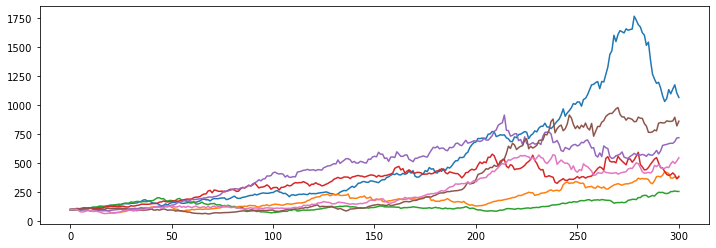

None

Fanchart


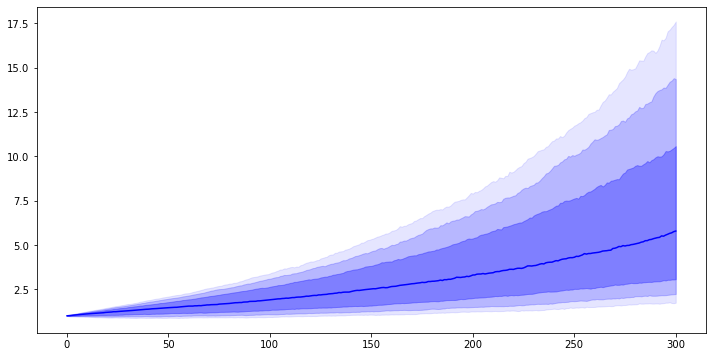

None

Percentaile summary


,12,36,60,120,240,300
10,0.935142,0.893553,0.900614,0.983494,1.404888,1.740133
15,0.975510,0.974829,1.010362,1.154921,1.709939,2.234444
25,1.031564,1.103800,1.167431,1.431116,2.371265,3.066580
50,1.126853,1.348382,1.548859,2.126537,4.073596,5.784785
75,1.215602,1.578090,1.930010,3.047797,7.138392,10.578500
85,1.266719,1.697784,2.148845,3.638865,9.464065,14.361773
90,1.296204,1.798514,2.280462,4.067903,10.890382,17.610818


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.068678,0.136902,-0.607310,1.974744,1.048373,-0.443572
std,0.035847,0.013430,0.289098,0.970884,0.988529,0.139041
min,-0.065392,0.093169,-2.268473,0.000003,-1.892455,-0.898275
25%,0.044822,0.127685,-0.789393,1.317466,0.359524,-0.528147
50%,0.070209,0.137076,-0.603852,1.819812,1.019281,-0.428713
75%,0.094353,0.146137,-0.421008,2.446947,1.710268,-0.342928
max,0.178611,0.183527,0.413335,12.023239,5.149694,-0.118881


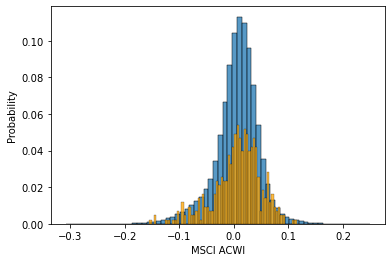

In [10]:
mus,sigmas,transition_matrix,current_regime = estimate_markov_regime_switching_params(acwi_returns,('2003-01-01', '2015-12-31'))
params_summary(mus,sigmas,transition_matrix,current_regime)

show_RSLN_scenarios_evaluation(mus,sigmas,transition_matrix,
                               initial_values=100,
                               current_regime=0,
                               dt=1,
                               n_scenarios=2000,
                               n_steps= 300,
                               hist=acwi_returns)

In [11]:
periods = [('1988-01-01', '2023-07-01'),
           ('1988-01-01', '2019-12-31'),
           ('1993-01-01', '2023-07-01'),
           ('1994-01-01', '2023-07-01'),
           ('2003-07-01', '2023-07-01'),
           ('1990-01-01', '2019-12-01'),
           ('1990-01-01', '2023-12-01'),
           ('2003-01-01', '2019-12-01'),
           ('2003-01-01', '2014-12-01'),
           ('2003-01-01', '2015-12-31')
           ]

data = acwi_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    params.append(np.round(result.params * 100,2))

params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1988-01-01, 2023-07-01)",93.49,9.16,1.60,-0.58,0.07,0.32
"(1988-01-01, 2019-12-31)",94.95,6.50,1.51,-0.35,0.07,0.30
"(1993-01-01, 2023-07-01)",94.23,7.22,1.43,-0.19,0.06,0.31
"(1994-01-01, 2023-07-01)",94.33,6.71,1.36,-0.24,0.06,0.31
"(2003-07-01, 2023-07-01)",92.99,14.73,1.39,-0.67,0.05,0.32
"(1990-01-01, 2019-12-01)",95.13,4.81,1.35,-0.16,0.06,0.30
"(1990-01-01, 2023-12-01)",93.66,6.51,1.45,-0.26,0.06,0.31
"(2003-01-01, 2019-12-01)",94.63,11.42,1.31,-0.62,0.05,0.29
"(2003-01-01, 2014-12-01)",96.17,9.18,1.25,-0.92,0.05,0.32
"(2003-01-01, 2015-12-31)",95.46,8.43,1.33,-0.91,0.06,0.32


Sample paths


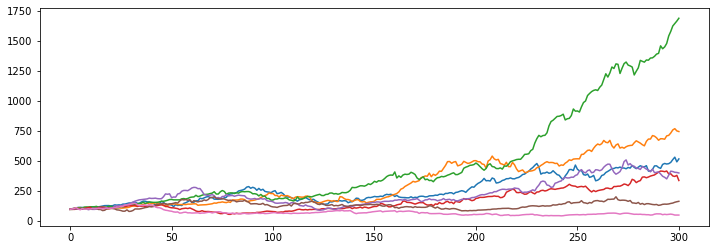

None

Fanchart


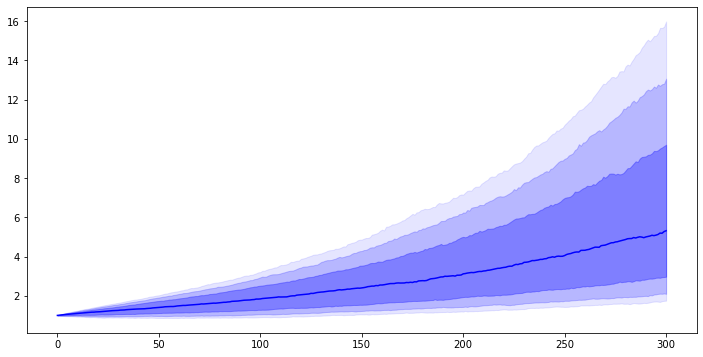

None

Percentaile summary


,12,36,60,120,240,300
10,0.933668,0.882604,0.871573,0.947764,1.400567,1.751141
15,0.967906,0.963583,0.980168,1.106191,1.666565,2.100397
25,1.030866,1.072791,1.144553,1.388830,2.295144,2.973568
50,1.120227,1.305333,1.487875,2.050614,3.884630,5.316158
75,1.202648,1.537434,1.866057,2.851601,6.491777,9.702257
85,1.255335,1.669174,2.096940,3.438044,8.306009,13.068044
90,1.286961,1.767274,2.244071,3.880669,9.859620,15.984388


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.066617,0.142494,-0.574258,1.952334,0.940959,-0.440748
std,0.034597,0.012314,0.279574,0.889276,0.905744,0.128713
min,-0.057085,0.096012,-1.531629,0.160718,-1.894338,-0.900620
25%,0.043591,0.134214,-0.757457,1.326453,0.321350,-0.523317
50%,0.066830,0.142451,-0.572681,1.796748,0.897329,-0.430587
75%,0.090894,0.150870,-0.383947,2.411984,1.548498,-0.346076
max,0.172118,0.188047,0.368869,9.410567,5.127605,-0.158326


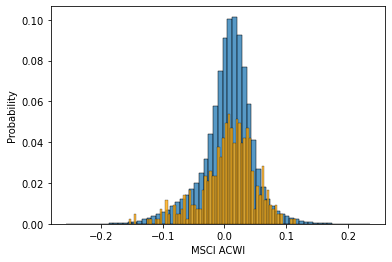

In [12]:
transition_matrix = [[0.93487726, 0.06512274],
                     [0.09158072, 0.90841928]]
mus = np.divide([ 0.16663396, -0.08022406],12)
sigmas = np.divide([0.07695315, 0.19668646], np.sqrt(12) )

show_RSLN_scenarios_evaluation(mus,sigmas,transition_matrix,
                               initial_values=100,
                               current_regime=0,
                               dt=1,
                               n_scenarios=2000,
                               n_steps= 300,
                               hist=acwi_returns)


In [13]:
eurpln = prep.loadStooqData('eurpln','1998-12-01','d')
eurpln = eurpln.resample('MS').last()
acwi_pln = (acwi * eurpln).dropna()
acwi_pln_returns = prep.log_returns(acwi_pln)


In [18]:
periods = [('1999-01-01', '2023-07-01'),
           ('1999-01-01', '2019-12-01'),
           ('1999-09-01', '2023-07-01'), 
           ('2001-01-01', '2023-07-01'),           
           ('2003-01-01', '2023-07-01'),
           ('2003-01-01', '2019-12-01'),           
           ('2013-07-01', '2023-07-01'),
           ('2008-07-01', '2023-07-01'),
           ]
prep.asset_stats(acwi_pln_returns, periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1999-01-01, 2023-07-01)",0.067608,0.132636,-0.483741,0.587445,0.982235,-0.499747
"(1999-01-01, 2019-12-01)",0.062245,0.131330,-0.608763,0.577828,0.850524,-0.499747
"(1999-09-01, 2023-07-01)",0.060150,0.132309,-0.485864,0.630770,0.789384,-0.499747
"(2001-01-01, 2023-07-01)",0.061872,0.129879,-0.487581,0.721854,0.850083,-0.409670
"(2003-01-01, 2023-07-01)",0.090461,0.121169,-0.319725,0.721826,1.728512,-0.409670
"(2003-01-01, 2019-12-01)",0.088652,0.116869,-0.472766,0.707478,1.738506,-0.409670
"(2013-07-01, 2023-07-01)",0.110610,0.118750,-0.111603,0.983353,2.351502,-0.148220
"(2008-07-01, 2023-07-01)",0.112648,0.117815,-0.233588,0.784225,2.430096,-0.148220


In [19]:
data = acwi_pln_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    params.append(np.round(result.params * 100,2))

params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1999-01-01, 2023-07-01)",95.75,11.08,1.31,-1.33,0.08,0.27
"(1999-01-01, 2019-12-01)",97.40,8.84,1.26,-1.86,0.08,0.27
"(1999-09-01, 2023-07-01)",95.36,9.58,1.25,-1.02,0.07,0.26
"(2001-01-01, 2023-07-01)",95.06,10.47,1.24,-1.06,0.07,0.26
"(2003-01-01, 2023-07-01)",95.66,14.28,1.21,-0.71,0.07,0.26
"(2003-01-01, 2019-12-01)",97.47,13.01,1.14,-1.29,0.07,0.27
"(2013-07-01, 2023-07-01)",91.17,13.63,1.28,0.41,0.05,0.21
"(2008-07-01, 2023-07-01)",93.81,11.36,1.24,0.36,0.05,0.23


Sample paths


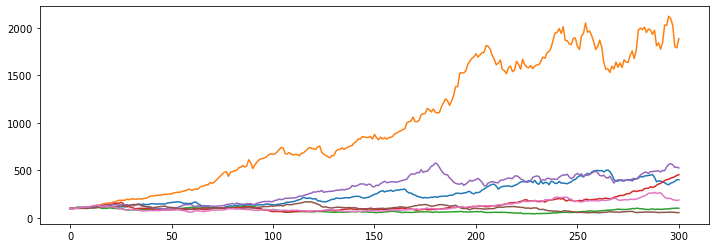

None
Fanchart


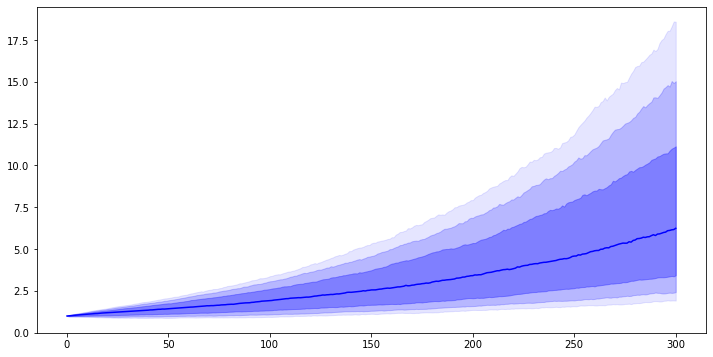

None
Percentaile summary


,12,36,60,120,240,300
10,0.946764,0.884459,0.914239,1.009583,1.536530,1.922158
15,0.977162,0.969084,1.016351,1.166365,1.912692,2.430505
25,1.030534,1.095925,1.173292,1.464631,2.555938,3.433452
50,1.130948,1.312983,1.523380,2.141899,4.299380,6.242079
75,1.220784,1.558004,1.915396,3.025657,7.365941,11.144842
85,1.278474,1.699566,2.163158,3.643620,9.373902,15.040226
90,1.309924,1.795417,2.315975,4.086740,11.042797,18.595980


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.071776,0.131226,-0.534888,1.275045,1.153865,-0.423928
std,0.035462,0.009939,0.231040,0.738019,0.989548,0.135922
min,-0.056627,0.104645,-1.518267,-0.286866,-2.013853,-0.918808
25%,0.049343,0.124454,-0.685220,0.767527,0.485129,-0.509731
50%,0.073253,0.130753,-0.528865,1.157876,1.136705,-0.409156
75%,0.096439,0.137887,-0.384077,1.645054,1.816083,-0.325632
max,0.190206,0.167282,0.308853,7.892056,5.096458,-0.141456


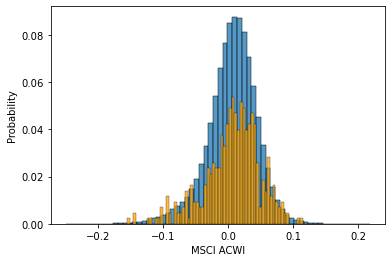

In [29]:
transition_matrix = [[0.958, 0.042],
                     [0.111, 0.889]]
mus = [ 0.0131, -0.0133]
sigmas = np.sqrt([0.0008, 0.0027])

show_RSLN_scenarios_evaluation(mus,sigmas,transition_matrix,
                               initial_values=100,
                               current_regime=0,
                               dt=1,
                               n_scenarios=2000,
                               n_steps= 300,
                               hist=acwi_returns)

5,7.2,9.6

### porownanie
regime switching 1990-2013:  
params .. 
curretirns percentile  
|1 | 2 | 3 |
| .. | ... | ... |  
assets stats 